In [183]:
# Import important standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve, RocCurveDisplay

In [184]:
# Read transformed data
combine_raw_df  = pd.read_csv('resources/combine_df.csv')

combine_raw_df.head()

,Year,Name,College,POS,Height (in),Weight (lbs),BMI,40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone
0,1987,Mike Adams,Arizona State,CB,69.8,198.0,28.6,4.42,13.0,32.0,118.0,4.60,NaN
1,1987,John Adickes,Baylor,C,74.8,266.0,33.4,4.97,25.0,26.5,103.0,4.60,NaN
2,1987,Tommy Agee,Auburn,FB,71.8,217.0,29.6,NaN,15.0,NaN,NaN,NaN,NaN
3,1987,David Alexander,Tulsa (OK),C,75.0,279.0,34.9,5.13,22.0,27.5,105.0,4.33,NaN
4,1987,Lyneal Alston,Southern Mississippi,WR,72.1,202.0,27.3,4.64,7.0,32.0,114.0,4.52,NaN


<AxesSubplot:ylabel='Frequency'>

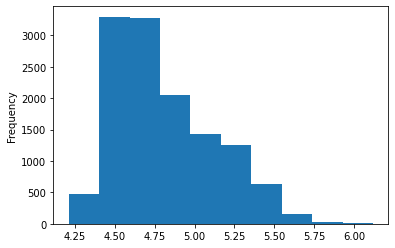

In [185]:
combine_raw_df['40 Yard'].plot.hist()

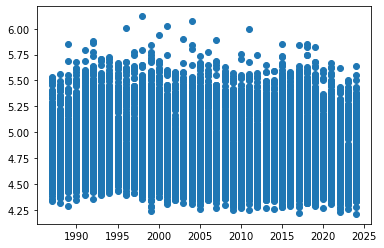

In [186]:
fig, ax = plt.subplots()
ax.scatter(combine_raw_df['Year'],combine_raw_df['40 Yard'])

In [187]:
combine_df_ml = combine_raw_df.copy()

# This will turn all of the string values to category values
for label, content in combine_df_ml.items():
    if pd.api.types.is_string_dtype(content):
        combine_df_ml[label] = content.astype("category").cat.as_ordered()

combine_df_ml.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14164 entries, 0 to 14163
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Year             14164 non-null  int64   
 1   Name             14164 non-null  category
 2   College          14157 non-null  category
 3   POS              14164 non-null  category
 4   Height (in)      14164 non-null  float64 
 5   Weight (lbs)     14164 non-null  float64 
 6   BMI              14164 non-null  float64 
 7   40 Yard          12634 non-null  float64 
 8   Bench Press      10276 non-null  float64 
 9   Vert Leap (in)   12178 non-null  float64 
 10  Broad Jump (in)  12055 non-null  float64 
 11  Shuttle          11099 non-null  float64 
 12  3Cone            3810 non-null   float64 
dtypes: category(3), float64(9), int64(1)
memory usage: 1.8 MB


In [188]:
combine_df_ml.isnull().sum()

Year                   0
Name                   0
College                7
POS                    0
Height (in)            0
Weight (lbs)           0
BMI                    0
40 Yard             1530
Bench Press         3888
Vert Leap (in)      1986
Broad Jump (in)     2109
Shuttle             3065
3Cone              10354
dtype: int64

In [189]:
combine_df_ml.drop(columns=['Bench Press', '3Cone'], inplace=True)
combine_df_ml.dropna(inplace=True)

In [190]:
combine_df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10734 entries, 0 to 14160
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Year             10734 non-null  int64   
 1   Name             10734 non-null  category
 2   College          10734 non-null  category
 3   POS              10734 non-null  category
 4   Height (in)      10734 non-null  float64 
 5   Weight (lbs)     10734 non-null  float64 
 6   BMI              10734 non-null  float64 
 7   40 Yard          10734 non-null  float64 
 8   Vert Leap (in)   10734 non-null  float64 
 9   Broad Jump (in)  10734 non-null  float64 
 10  Shuttle          10734 non-null  float64 
dtypes: category(3), float64(7), int64(1)
memory usage: 1.4 MB


In [191]:
for label, content in combine_df_ml.items():
    if not pd.api.types.is_numeric_dtype(content):
        #Turn categories into numbers and add +1
        combine_df_ml[label] = pd.Categorical(content).codes + 1

In [192]:
combine_df_ml.head()

,Year,Name,College,POS,Height (in),Weight (lbs),BMI,40 Yard,Vert Leap (in),Broad Jump (in),Shuttle
0,1987,9478,18,2,69.8,198.0,28.6,4.42,32.0,118.0,4.60
1,1987,6729,31,1,74.8,266.0,33.4,4.97,26.5,103.0,4.60
3,1987,3377,385,1,75.0,279.0,34.9,5.13,27.5,105.0,4.33
4,1987,8654,343,25,72.1,202.0,27.3,4.64,32.0,114.0,4.52
5,1987,11968,404,4,76.5,273.0,32.8,4.86,28.5,108.0,4.49


In [193]:
# Split data into training and validation
df_val = combine_df_ml[combine_df_ml.Year > 2017]
df_train = combine_df_ml[combine_df_ml.Year <= 2017]

len(df_val)/len(combine_df_ml), len(df_train)/len(combine_df_ml)

(0.18567169741009876, 0.8143283025899013)

In [194]:
# Split data into X and y
X_train, y_train = df_train.drop("40 Yard", axis=1), df_train['40 Yard']
X_valid, y_valid = df_val.drop("40 Yard", axis=1), df_val['40 Yard']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((8741, 10), (8741,), (1993, 10), (1993,))

In [195]:
# Create evaluation function
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculate root mean squared log error between predicitions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model o na few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
            "Valid MAE": mean_absolute_error(y_valid, val_preds),
            "Training RMSLE": rmsle(y_train, train_preds),
            "Valid RMSLE": rmsle(y_valid, val_preds),
            "Training R^2": r2_score(y_train, train_preds),
            "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

In [196]:
# Instantiate model 
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

In [197]:
%%time
# Cutting down the max number of samples for each estimator can improve training time.
model.fit(X_train, y_train)

Wall time: 801 ms


RandomForestRegressor(n_jobs=-1, random_state=42)

In [198]:
show_scores(model)

{'Training MAE': 0.03368833085459327,
 'Valid MAE': 0.09032293025589565,
 'Training RMSLE': 0.007372022913941376,
 'Valid RMSLE': 0.01993211448031383,
 'Training R^2': 0.9804756017625536,
 'Valid R^2': 0.8528710472845064}

In [199]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [200]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Dfferent RandomForestRegressor hyper parameters
rs_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rs_grid,
                              n_iter=1000,
                              cv=5,
                              verbose=True)

# For the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Wall time: 24min 6s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=1000,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [201]:
# Find the best hyperparams
rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 16,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': None}

In [202]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 0.06633246060091112,
 'Valid MAE': 0.08940170647390298,
 'Training RMSLE': 0.014507669771399,
 'Valid RMSLE': 0.019700490889376965,
 'Training R^2': 0.9242326275658925,
 'Valid R^2': 0.8563116966442141}

In [203]:
import xgboost

xgb_model = XGBRegressor(n_jobs=-1, random_state = 42)

xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [204]:
show_scores(xgb_model)

{'Training MAE': 0.05249212059027105,
 'Valid MAE': 0.0953184432045515,
 'Training RMSLE': 0.011759053133367158,
 'Valid RMSLE': 0.020939833690793132,
 'Training R^2': 0.9516209653723701,
 'Valid R^2': 0.8374677433918217}

In [205]:
# Instantiate RandomizedSearchCV model for XGBoost
rs_xgb_model = RandomizedSearchCV(XGBRegressor(n_jobs=-1,
                                        random_state=42),
                              param_distributions=rs_grid,
                              n_iter=1000,
                              cv=5,
                              verbose=True)

In [206]:
rs_xgb_model.fit(X_train,y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[23:55:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:55:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:55:54] 

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          num_parallel_tree=None,
                                        

In [207]:
# Evaluate the RandomizedSearch model
show_scores(rs_xgb_model)

{'Training MAE': 0.0817503016857762,
 'Valid MAE': 0.09284939613284864,
 'Training RMSLE': 0.017727338256830847,
 'Valid RMSLE': 0.020212480816343494,
 'Training R^2': 0.8878191843361087,
 'Valid R^2': 0.8484212541862255}

### Reduce the Number of Inputs

Can we make accurate predictions on 40 times based on weight, height, bmi, and vertical jump alone?

- Let's reduce the number of variables.
- Check correlation.
- Rerun models.

In [208]:
combine_df_ml.columns

Index(['Year', 'Name', 'College', 'POS', 'Height (in)', 'Weight (lbs)', 'BMI',
       '40 Yard', 'Vert Leap (in)', 'Broad Jump (in)', 'Shuttle'],
      dtype='object')

In [209]:
combine_df_reduced_ml = combine_df_ml.drop(columns=['Name', 'College', 'POS', 
                                                    'Broad Jump (in)', 'Shuttle',])

combine_df_reduced_ml.head()

,Year,Height (in),Weight (lbs),BMI,40 Yard,Vert Leap (in)
0,1987,69.8,198.0,28.6,4.42,32.0
1,1987,74.8,266.0,33.4,4.97,26.5
3,1987,75.0,279.0,34.9,5.13,27.5
4,1987,72.1,202.0,27.3,4.64,32.0
5,1987,76.5,273.0,32.8,4.86,28.5


In [210]:
combine_df_reduced_ml.corr().abs()['40 Yard'].sort_values(ascending=False)

40 Yard           1.000000
Weight (lbs)      0.833898
BMI               0.778767
Vert Leap (in)    0.750292
Height (in)       0.611854
Year              0.134414
Name: 40 Yard, dtype: float64

It's interesting how much weight had an impact on correlation. Height is still significant, but clearly not as much as weight. In this case it appears that time is almost insignificant when analyzing 40 yard performance, but when we look at charts there is a downward trend. It would be interesting to compare just the average for the year to time and see how correlation compares. From external knowledge it's clear that performance science and athletic ability have improved over time. When we have other factors such as weight this is drowned out. 

In [211]:
# Use our Random Forest Model on the reduced dataframe

# Split data into training and validation
df_val = combine_df_reduced_ml[combine_df_reduced_ml.Year > 2017]
df_train = combine_df_reduced_ml[combine_df_reduced_ml.Year <= 2017]

# Split data into X and y
X_train, y_train = df_train.drop("40 Yard", axis=1), df_train['40 Yard']
X_valid, y_valid = df_val.drop("40 Yard", axis=1), df_val['40 Yard']

model.fit(X_train, y_train)

show_scores(model)

{'Training MAE': 0.03782515185687591,
 'Valid MAE': 0.10651981727713664,
 'Training RMSLE': 0.008333700208911193,
 'Valid RMSLE': 0.023541073162603794,
 'Training R^2': 0.974904106232037,
 'Valid R^2': 0.7936126696678742}